In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#!pip install geopandas matplotlib requests
import geopandas as gpd
import requests
import json


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
filepath = 'https://raw.githubusercontent.com/S1mDu/DataScienceMachineLearning/refs/heads/main/Data/National/'

# NATIONAL DATA ANALYSIS

## Preliminary Graphs

In [3]:
car_df = pd.read_csv( filepath + 'CH_vehicles_ev_percentage.csv')
pm10 = pd.read_csv(filepath + 'PM10_emissions_CH.csv')
no2 = pd.read_csv(filepath + 'No2_emissions_CH.csv')
co2 = pd.read_csv(filepath + 'CO2_carb_comb.csv')

In [4]:
co2.columns = ['year', 'carburants', 'combustibles', 'total']

In [5]:
# Step 1: Melt the wide dataframe into long format
clean_car_df = car_df.melt(id_vars='fuel_type', var_name='year', value_name='value')

# Step 2: Convert year to integer and standardize fuel_type
clean_car_df['year'] = clean_car_df['year'].astype(int)
clean_car_df['fuel_type'] = clean_car_df['fuel_type'].str.strip()

# Preview result
clean_car_df.head(2)

fuel_type  year      value
0       Fossil  1990  3773139.0
1  Electricity  1990     3690.0

In [6]:
no2.rename(columns={no2.columns[1]: 'No2 ug/m3'}, inplace=True)
pm10.rename(columns={pm10.columns[1]: 'Pm10 ug/m3'}, inplace=True)


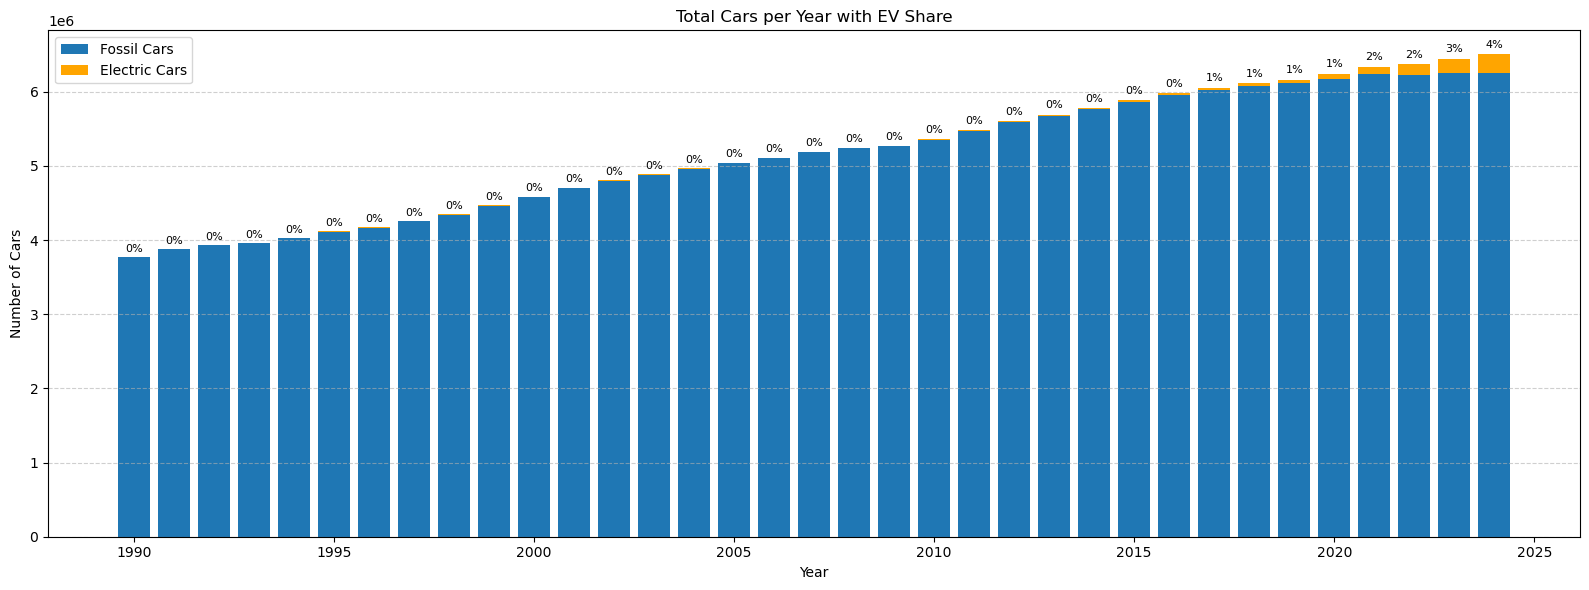

In [7]:
# Step 1: Set 'fuel_type' as index
car_df_clean = car_df.set_index("fuel_type")

# Step 2: Drop the "% EV vs Fossil" row
car_data = car_df_clean.drop("% EV vs Fossil")

# Step 3: Transpose the data
df_transposed = car_data.T
df_transposed.columns = ["Fossil", "Electricity"]
df_transposed.index.name = "Year"
df_transposed = df_transposed.reset_index()
df_transposed["Year"] = df_transposed["Year"].astype(int)

# Step 4: Calculate EV share %
df_transposed["EV_share_pct"] = (df_transposed["Electricity"] /
                                 (df_transposed["Electricity"] + df_transposed["Fossil"])) * 100

# Step 5: Plot
plt.figure(figsize=(16, 6))
plt.bar(df_transposed["Year"], df_transposed["Fossil"], label="Fossil Cars")
plt.bar(df_transposed["Year"], df_transposed["Electricity"],
        bottom=df_transposed["Fossil"], label="Electric Cars", color="orange")

# Add % text labels above the bars
for i, row in df_transposed.iterrows():
    total_height = row["Fossil"] + row["Electricity"]
    pct = round(row["EV_share_pct"])
    plt.text(row["Year"], total_height + total_height * 0.01,  # slightly above the bar
             f"{pct}%", ha='center', va='bottom', fontsize=8)

plt.xlabel("Year")
plt.ylabel("Number of Cars")
plt.title("Total Cars per Year with EV Share")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

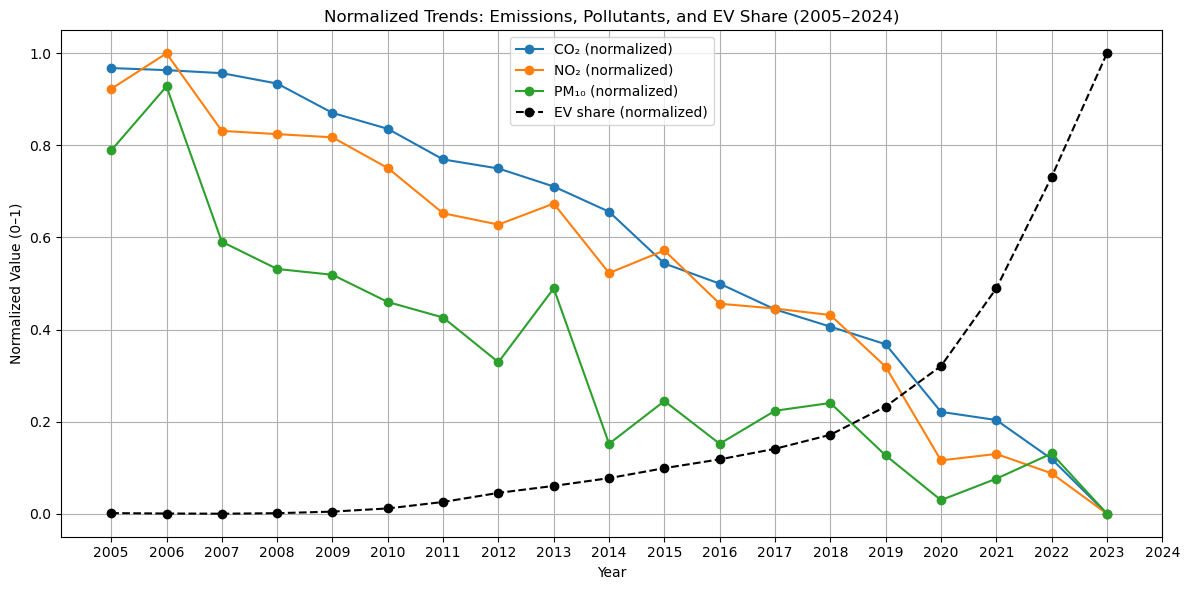

In [8]:
# Clean column names
clean_car_df.columns = clean_car_df.columns.str.strip()

# Extract and rename EV share
ev_share_only = clean_car_df[clean_car_df['fuel_type'] == '% EV vs Fossil'][['year', 'value']]
ev_share_only.rename(columns={'value': 'EV_share'}, inplace=True)

# Rename date to year for merging
no2.rename(columns={'date': 'year'}, inplace=True)
pm10.rename(columns={'date': 'year'}, inplace=True)

# Merge datasets
merged = co2[['year', 'total']].merge(no2, on='year') \
                               .merge(pm10, on='year') \
                               .merge(ev_share_only, on='year')

# Normalize all values using min-max scaling
merged['CO2_norm'] = (merged['total'] - merged['total'].min()) / (merged['total'].max() - merged['total'].min())
merged['NO2_norm'] = (merged['No2 ug/m3'] - merged['No2 ug/m3'].min()) / (merged['No2 ug/m3'].max() - merged['No2 ug/m3'].min())
merged['PM10_norm'] = (merged['Pm10 ug/m3'] - merged['Pm10 ug/m3'].min()) / (merged['Pm10 ug/m3'].max() - merged['Pm10 ug/m3'].min())
merged['EV_norm'] = (merged['EV_share'] - merged['EV_share'].min()) / (merged['EV_share'].max() - merged['EV_share'].min())

# Filter data for years 2005–2024
merged = merged[merged['year'].between(2005, 2024)]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(merged['year'], merged['CO2_norm'], label='CO₂ (normalized)', marker='o')
plt.plot(merged['year'], merged['NO2_norm'], label='NO₂ (normalized)', marker='o')
plt.plot(merged['year'], merged['PM10_norm'], label='PM₁₀ (normalized)', marker='o')
plt.plot(merged['year'], merged['EV_norm'], label='EV share (normalized)', color='black', linestyle='--', marker='o')

# Formatting
plt.title("Normalized Trends: Emissions, Pollutants, and EV Share (2005–2024)")
plt.xlabel("Year")
plt.ylabel("Normalized Value (0–1)")
plt.xticks(range(2005, 2025))  # Round years only
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [9]:
# Create a DataFrame with only normalized columns
correlation_df = merged[['EV_norm', 'CO2_norm', 'NO2_norm', 'PM10_norm']]

# Compute correlation matrix
correlation_matrix = correlation_df.corr()

# Display only correlations with EV
ev_correlations = correlation_matrix[['EV_norm']].drop('EV_norm')

print("Correlation of EV share with each pollutant/emission:")
print(ev_correlations)


Correlation of EV share with each pollutant/emission:
            EV_norm
CO2_norm  -0.871281
NO2_norm  -0.855695
PM10_norm -0.652598


## Swiss GIF

In [10]:
EV_share = pd.read_csv(filepath + 'EV_share.csv')
EV_absolute = pd.read_csv(filepath + 'EV_absolute.csv')
cars_number = pd.read_csv(filepath + 'cars_number.csv')
canton_detailed = pd.read_csv(filepath + 'cantonal_vehicles_grouped_by_abbr.csv')

In [11]:
# Load your uploaded canton GeoJSON file
gdf = gpd.read_file(filepath + 'georef-switzerland-kanton.geojson')

Skipping field kan_code: unsupported OGR type: 5
Skipping field kan_name: unsupported OGR type: 5


In [12]:
latest_year = EV_share['date'].max()
ev_latest = EV_share[EV_share['date'] == latest_year].copy().iloc[0]
ev_share_dict = {col: float(ev_latest[col]) for col in EV_share.columns if col != 'date'}

In [13]:
# Reload with geopandas to preserve geometry
gdf = gpd.read_file(filepath + 'georef-switzerland-kanton.geojson')

# Extract 'kan_name' from the raw GeoJSON using requests
import json
response = requests.get(filepath + 'georef-switzerland-kanton.geojson')
data = json.loads(response.content)

# Extract canton names
canton_names = [feature['properties']['kan_name'] for feature in data['features']]
gdf['kan_name'] = canton_names

# Preview
print(gdf[['kan_name']].head())

Skipping field kan_code: unsupported OGR type: 5
Skipping field kan_name: unsupported OGR type: 5


                   kan_name
0                 [Thurgau]
1            [Schaffhausen]
2                  [Schwyz]
3  [Appenzell Ausserrhoden]
4        [Basel-Landschaft]


In [14]:
canton_abbr = {
    'Aargau': 'AG', 'Appenzell Ausserrhoden': 'AR', 'Appenzell Innerrhoden': 'AI',
    'Basel-Landschaft': 'BL', 'Basel-Stadt': 'BS', 'Bern': 'BE', 'Fribourg': 'FR',  # <-- use 'Freiburg'
    'Genève': 'GE', 'Glarus': 'GL', 'Graubünden': 'GR', 'Jura': 'JU', 'Luzern': 'LU',
    'Neuchâtel': 'NE', 'Nidwalden': 'NW', 'Obwalden': 'OW', 'Schaffhausen': 'SH',
    'Schwyz': 'SZ', 'Solothurn': 'SO', 'St. Gallen': 'SG', 'Thurgau': 'TG',
    'Ticino': 'TI', 'Uri': 'UR', 'Valais': 'VS', 'Vaud': 'VD', 'Zug': 'ZG',
    'Zürich': 'ZH'
}
gdf['kan_name_str'] = gdf['kan_name'].str[0]
gdf['abbr'] = gdf['kan_name_str'].map(canton_abbr)
gdf['EV_share'] = gdf['abbr'].map(ev_share_dict)

In [15]:
latest_year = EV_share['date'].max()
ev_latest = EV_share[EV_share['date'] == latest_year].iloc[0]
ev_share_dict = {col: float(ev_latest[col]) for col in EV_share.columns if col != 'date'}

# Add EV share to GeoDataFrame
gdf['EV_share'] = gdf['abbr'].map(ev_share_dict)


In [16]:
latest_year = EV_absolute['date'].max()
ev_abs_latest = EV_absolute[EV_absolute['date'] == latest_year].iloc[0]
ev_abs_dict = {col: int(ev_abs_latest[col]) for col in EV_absolute.columns if col != 'date'}
# Already done:
# gdf['abbr'] = gdf['kan_name'].map(canton_abbr)

gdf['EV_absolute'] = gdf['abbr'].map(ev_abs_dict)

In [17]:
# Filter for rows where fuel_type is 'Electricity'
df_ev_2024 = canton_detailed[canton_detailed['fuel_type'] == 'Electricity'][['canton', '2024']].copy()

# Rename column for clarity
df_ev_2024.rename(columns={'2024': 'EV_2024'}, inplace=True)

# Ensure canton codes are uppercase
df_ev_2024['canton'] = df_ev_2024['canton'].str.upper()


In [18]:
# Pivot your canton_detailed to a wide format with fuel_type as rows and years as columns
df_electric = canton_detailed[canton_detailed['fuel_type'] == 'Electricity'].copy()

# Keep only canton and year columns
df_electric = df_electric.drop(columns=['fuel_type'])

# Melt to long format for merging by year
df_electric_long = df_electric.melt(id_vars='canton', var_name='year', value_name='EVs')
df_electric_long['year'] = df_electric_long['year'].astype(int)
df_electric_long['canton'] = df_electric_long['canton'].str.upper()

In [19]:
# Filter the rows for "% EV vs Fossil"
df_ratio = canton_detailed[canton_detailed['fuel_type'] == '% EV vs Fossil'].copy()

# Drop unneeded column
df_ratio = df_ratio.drop(columns=['fuel_type'])

# Melt to long format
df_ratio_long = df_ratio.melt(id_vars='canton', var_name='year', value_name='EV_ratio')
df_ratio_long['year'] = df_ratio_long['year'].astype(int)
df_ratio_long['canton'] = df_ratio_long['canton'].str.upper()

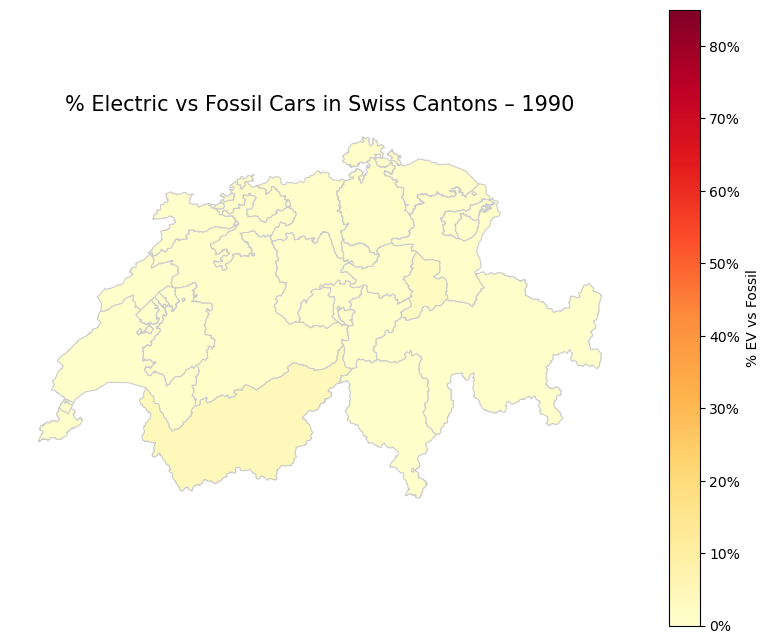

In [20]:
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.animation import FuncAnimation
import matplotlib.ticker as mtick

# Setup
fig, ax = plt.subplots(figsize=(10, 8))
years = sorted(df_ratio_long['year'].unique())
base_gdf = gdf[['geometry', 'abbr', 'kan_name']].copy()

vmin = 0
vmax = df_ratio_long['EV_ratio'].max()

# Colorbar setup
sm = ScalarMappable(norm=Normalize(vmin=10*vmin, vmax=10*vmax), cmap='YlOrRd')
sm._A = []
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("% EV vs Fossil")

# Format tick labels as percentages
cbar.ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))

def update(year):
    ax.clear()
    df_year = df_ratio_long[df_ratio_long['year'] == year]
    merged = base_gdf.merge(df_year, how='left', left_on='abbr', right_on='canton')

    merged.plot(
        column='EV_ratio',
        cmap='YlOrRd',
        linewidth=0.8,
        ax=ax,
        edgecolor='0.8',
        vmin=vmin,
        vmax=vmax,
        missing_kwds={"color": "lightgrey"}
    )

    ax.set_title(f'% Electric vs Fossil Cars in Swiss Cantons – {year}', fontsize=15)
    ax.axis('off')

ani = FuncAnimation(fig, update, frames=years, repeat=False)

from IPython.display import HTML
HTML(ani.to_jshtml())


## Correlation and statistic coefficients

In [21]:
#!pip install ace-tools
import statsmodels.api as sm
import seaborn as sns

In [22]:
# Load your datasets (use your own file paths in Colab)
no2_df = pd.read_csv(filepath + "No2_emissions_CH.csv")
ev_df = pd.read_csv(filepath + "CH_vehicles_ev_percentage.csv")
swiss_df = pd.read_csv(filepath + 'swiss_final_dataset_1995_2023.csv')
pm10_df = pd.read_csv(filepath + 'PM10_emissions_CH.csv')
co2_df = pd.read_csv(filepath + 'CO2_emissions.csv')

In [23]:
# Rename columns for easier access
co2_df.columns = ['year', 'emissions_carburants', 'emissions_combustibles', 'CO2']

# Keep only year and CO2 columns
co2_df = co2_df[['year', 'CO2']]

In [24]:
# Rename the 'date' column in no2_df to 'year' so it matches swiss_df
no2_df = no2_df.rename(columns={'date': 'year'})

# Merge the two DataFrames on the 'year' column
merged_df = pd.merge(no2_df, swiss_df, on='year')

In [25]:
# Create the new column 'EV_share' as the ratio of Electricity to Fossil
merged_df['EV_share'] = merged_df['Electricity'] / merged_df['Fossil']

In [26]:
# Define Y and X
Y = merged_df['NO2 [ug/m3]']
X = merged_df['industry_pct_gdp']

# Add constant to the predictor (intercept)
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(Y, X).fit()

# Display the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            NO2 [ug/m3]   R-squared:                       0.273
Model:                            OLS   Adj. R-squared:                  0.239
Method:                 Least Squares   F-statistic:                     7.896
Date:                Wed, 21 May 2025   Prob (F-statistic):             0.0105
Time:                        17:57:15   Log-Likelihood:                -78.008
No. Observations:                  23   AIC:                             160.0
Df Residuals:                      21   BIC:                             162.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             -115.1491     55.496  

In [27]:
# Define the dependent and independent variables
Y = merged_df['NO2 [ug/m3]']
X = merged_df['EV_share']

# Add a constant to the independent variable (intercept term)
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(Y, X).fit()

# Print the summary of the model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            NO2 [ug/m3]   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                     55.24
Date:                Wed, 21 May 2025   Prob (F-statistic):           2.63e-07
Time:                        17:57:15   Log-Likelihood:                -66.852
No. Observations:                  23   AIC:                             137.7
Df Residuals:                      21   BIC:                             140.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         45.9728      1.196     38.435      0.0

In [28]:
# If pm10_df uses 'date', rename it to 'year' for consistency
pm10_df = pm10_df.rename(columns={'date': 'year'})

# Merge with the existing merged_df on 'year'
merged_df = pd.merge(merged_df, pm10_df, on='year')
# Merge with merged_df on 'year'
merged_df = pd.merge(merged_df, co2_df, on='year')
merged_df['log_population'] = np.log(merged_df['population'])


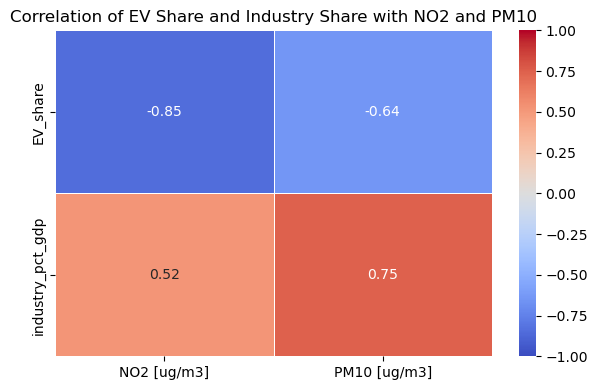

In [29]:
# Filter data from 2002 onward
filtered_df = merged_df[merged_df['year'] >= 2002]

# Select relevant columns
cols = ['EV_share', 'industry_pct_gdp', 'NO2 [ug/m3]', 'PM10 [ug/m3]']
corr_matrix = filtered_df[cols].corr()

# Focused correlation matrix
focused_corr = corr_matrix.loc[['EV_share', 'industry_pct_gdp'], ['NO2 [ug/m3]', 'PM10 [ug/m3]']]

# Plot heatmap with scale fixed from -1 to 1
plt.figure(figsize=(6, 4))
sns.heatmap(focused_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation of EV Share and Industry Share with NO2 and PM10')
plt.tight_layout()
plt.show()

In [30]:
# Dependent variables
dependent_vars = ['NO2 [ug/m3]', 'PM10 [ug/m3]', 'CO2']

# Store results
univariate_results = []
multivariate_results = []

for y_var in dependent_vars:
    df_clean = merged_df[[y_var, 'EV_share', 'industry_pct_gdp']].dropna()
    Y = df_clean[y_var]

    # Univariate: EV_share
    X1 = sm.add_constant(df_clean['EV_share'])
    model1 = sm.OLS(Y, X1).fit()
    univariate_results.append({
        'Y': y_var,
        'Predictor': 'EV_share',
        'R2': model1.rsquared,
        'coef': model1.params['EV_share'],
        'p-value': model1.pvalues['EV_share']
    })

    # Univariate: industry_pct_gdp
    X2 = sm.add_constant(df_clean['industry_pct_gdp'])
    model2 = sm.OLS(Y, X2).fit()
    univariate_results.append({
        'Y': y_var,
        'Predictor': 'industry_pct_gdp',
        'R2': model2.rsquared,
        'coef': model2.params['industry_pct_gdp'],
        'p-value': model2.pvalues['industry_pct_gdp']
    })

    # Multivariate: both
    X3 = sm.add_constant(df_clean[['EV_share', 'industry_pct_gdp']])
    model3 = sm.OLS(Y, X3).fit()
    multivariate_results.append({
        'Y': y_var,
        'R2': model3.rsquared,
        'Adj_R2': model3.rsquared_adj,
        'EV_share_coef': model3.params['EV_share'],
        'EV_share_p': model3.pvalues['EV_share'],
        'Industry_coef': model3.params['industry_pct_gdp'],
        'Industry_p': model3.pvalues['industry_pct_gdp']
    })

# Create dataframes
univariate_df = pd.DataFrame(univariate_results)
multivariate_df = pd.DataFrame(multivariate_results)

# Display results
print("📘 Univariate OLS Results")
display(univariate_df.round(3))

print("\n📗 Multivariate OLS Results")
display(multivariate_df.round(3))

📘 Univariate OLS Results


Y         Predictor     R2     coef  p-value
0   NO2 [ug/m3]          EV_share  0.725 -953.825    0.000
1   NO2 [ug/m3]  industry_pct_gdp  0.273    6.196    0.010
2  PM10 [ug/m3]          EV_share  0.412 -603.740    0.002
3  PM10 [ug/m3]  industry_pct_gdp  0.556    7.769    0.000
4           CO2          EV_share  0.747 -399.391    0.000
5           CO2  industry_pct_gdp  0.345    2.870    0.003


📗 Multivariate OLS Results


Y     R2  Adj_R2  EV_share_coef  EV_share_p  Industry_coef  \
0   NO2 [ug/m3]  0.829   0.812       -861.780         0.0          3.948   
1  PM10 [ug/m3]  0.803   0.782       -478.469         0.0          6.667   
2           CO2  0.895   0.885       -354.006         0.0          1.946   

   Industry_p  
0       0.002  
1       0.000  
2       0.000

# Machine Learning Analysis

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [32]:
# Load your datasets (use your own file paths in Colab)
no2_df = pd.read_csv(filepath + "No2_emissions_CH.csv")
ev_df = pd.read_csv(filepath + "CH_vehicles_ev_percentage.csv")
swiss_df = pd.read_csv(filepath + 'swiss_final_dataset_1995_2023.csv')

In [33]:
no2_df = no2_df.rename(columns={'date': 'year'})

In [34]:
swiss_df['EV Share'] = swiss_df['Electricity'] / swiss_df['Fossil']
swiss_df['log_population'] = np.log(swiss_df['population'])
swiss_df = pd.merge(no2_df, swiss_df, on='year', how='inner')
swiss_df = swiss_df.rename(columns={'NO2 [ug/m3]': 'no2'})

## Train-Test EVshare and NO2

### Linear regression

In [35]:
# Define X and y
X = swiss_df[['EV Share']]
y = swiss_df[['no2']]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Fit linear regression
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

MSE: 7.844356508159256
MAE: 2.6895179856170808
R² Score: 0.8466701229835955


In [36]:
# Define X and y
X = swiss_df[['EV Share']]
y = swiss_df[['no2']]

# Initialize model
model = LinearRegression()

# Set up 5-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=0)

# Define custom scoring functions
mse_scorer = make_scorer(mean_squared_error)
mae_scorer = make_scorer(mean_absolute_error)
r2_scorer = make_scorer(r2_score)

# Perform cross-validation
mse_scores = cross_val_score(model, X, y, cv=kf, scoring=mse_scorer)
mae_scores = cross_val_score(model, X, y, cv=kf, scoring=mae_scorer)
r2_scores = cross_val_score(model, X, y, cv=kf, scoring=r2_scorer)

# Print average scores
print("Average MSE:", np.mean(mse_scores))
print("Average MAE:", np.mean(mae_scores))
print("Average R² Score:", np.mean(r2_scores))


Average MSE: 30.679816697881922
Average MAE: 4.526096283091893
Average R² Score: 0.3720447160625804


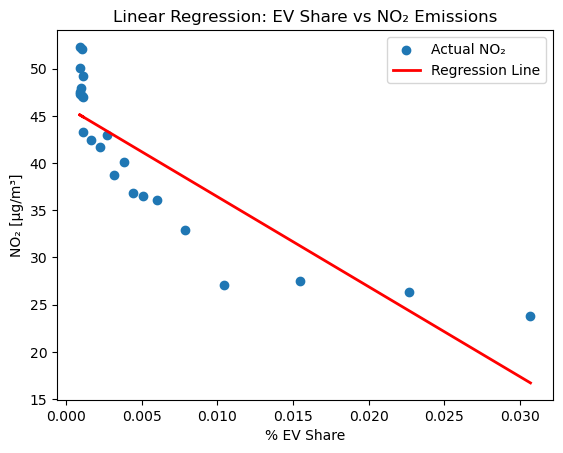

In [37]:
# Define X and y
X = swiss_df[['EV Share']]
y = swiss_df[['no2']]

# Fit the regression model on the full data
model = LinearRegression()
model.fit(X, y)

# Predict y values using the fitted model
y_pred = model.predict(X)

# Plot actual data and regression line
plt.scatter(X, y, label='Actual NO₂')
plt.plot(X, y_pred, color='red', linewidth=2, label='Regression Line')
plt.xlabel('% EV Share')
plt.ylabel('NO₂ [μg/m³]')
plt.title('Linear Regression: EV Share vs NO₂ Emissions')
plt.legend()
plt.show()

### Polynomial regression degree 2

MSE: 28.58609107244639
MAE: 4.450032754749527
R² Score: 0.44124137856828793


c:\Users\simon\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


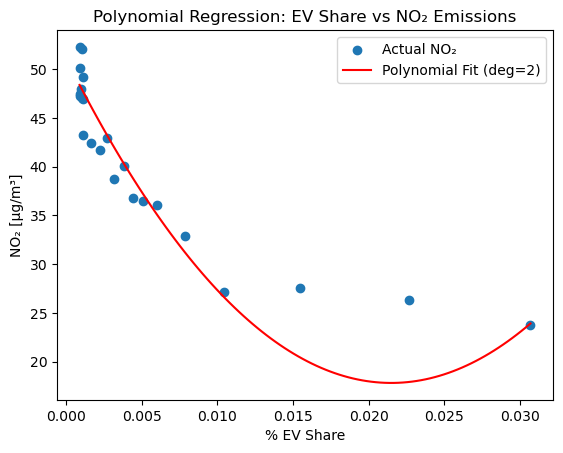

In [38]:
# 2. Define X and y
X = swiss_df[['EV Share']]
y = swiss_df[['no2']]

# 3. Transform features into polynomial (degree = 2)
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

# 4. Split the data
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=0)

# 5. Fit the model
model = LinearRegression()
model.fit(X_train, y_train)

# 6. Predict and evaluate
y_pred = model.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

# 7. Plot the curve
x_range = np.linspace(X['EV Share'].min(), X['EV Share'].max(), 100).reshape(-1, 1)
x_range_poly = poly.transform(x_range)
y_range_pred = model.predict(x_range_poly)

plt.scatter(X, y, label='Actual NO₂')
plt.plot(x_range, y_range_pred, color='red', label='Polynomial Fit (deg=2)')
plt.xlabel('% EV Share')
plt.ylabel('NO₂ [μg/m³]')
plt.title('Polynomial Regression: EV Share vs NO₂ Emissions')
plt.legend()
plt.show()

In [39]:
# Define X and y
X = swiss_df[['EV Share']]
y = swiss_df[['no2']]

# Define the pipeline: PolynomialFeatures + LinearRegression
degree = 2
model = make_pipeline(PolynomialFeatures(degree=degree), LinearRegression())

# Set up K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=0)

# Define scorers
mse_scorer = make_scorer(mean_squared_error)
mae_scorer = make_scorer(mean_absolute_error)
r2_scorer = make_scorer(r2_score)

# Perform cross-validation
mse_scores = cross_val_score(model, X, y, cv=kf, scoring=mse_scorer)
mae_scores = cross_val_score(model, X, y, cv=kf, scoring=mae_scorer)
r2_scores = cross_val_score(model, X, y, cv=kf, scoring=r2_scorer)

# Print average scores
print("Polynomial degree:", degree)
print("Average MSE:", np.mean(mse_scores))
print("Average MAE:", np.mean(mae_scores))
print("Average R² Score:", np.mean(r2_scores))


Polynomial degree: 2
Average MSE: 25.67906797431134
Average MAE: 3.350482465188631
Average R² Score: 0.5110139770652963


Polynomial regression degree 2

MSE: 4.247406229547461
MAE: 1.6596351117874029
R² Score: 0.9169779861308158


c:\Users\simon\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


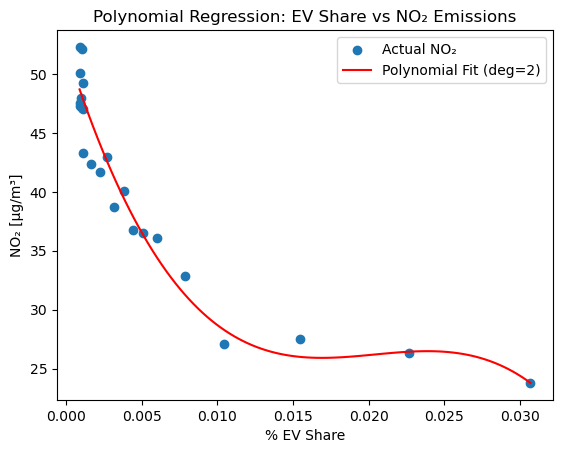

In [40]:
# 2. Define X and y
X = swiss_df[['EV Share']]
y = swiss_df[['no2']]

# 3. Transform features into polynomial (degree = 3)
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X)

# 4. Split the data
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=0)

# 5. Fit the model
model = LinearRegression()
model.fit(X_train, y_train)

# 6. Predict and evaluate
y_pred = model.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

# 7. Plot the curve
import numpy as np
x_range = np.linspace(X['EV Share'].min(), X['EV Share'].max(), 100).reshape(-1, 1)
x_range_poly = poly.transform(x_range)
y_range_pred = model.predict(x_range_poly)

plt.scatter(X, y, label='Actual NO₂')
plt.plot(x_range, y_range_pred, color='red', label='Polynomial Fit (deg=2)')
plt.xlabel('% EV Share')
plt.ylabel('NO₂ [μg/m³]')
plt.title('Polynomial Regression: EV Share vs NO₂ Emissions')
plt.legend()
plt.show()

In [41]:
# Define X and y
X = swiss_df[['EV Share']]
y = swiss_df[['no2']]

# Define the pipeline for Polynomial Regression with degree 3
degree = 3
model = make_pipeline(PolynomialFeatures(degree=degree), LinearRegression())

# Set up K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=0)

# Define scorers
mse_scorer = make_scorer(mean_squared_error)
mae_scorer = make_scorer(mean_absolute_error)
r2_scorer = make_scorer(r2_score)

# Perform cross-validation
mse_scores = cross_val_score(model, X, y, cv=kf, scoring=mse_scorer)
mae_scores = cross_val_score(model, X, y, cv=kf, scoring=mae_scorer)
r2_scores = cross_val_score(model, X, y, cv=kf, scoring=r2_scorer)

# Print results
print("Polynomial degree:", degree)
print("Average MSE:", np.mean(mse_scores))
print("Average MAE:", np.mean(mae_scores))
print("Average R² Score:", np.mean(r2_scores))


Polynomial degree: 3
Average MSE: 8.918131479588219
Average MAE: 2.1746533366078573
Average R² Score: 0.8151204025989998


### K-Fold cross-validation for the polynomial regression

In [42]:
# Use full data
X = swiss_df[['EV Share']]
y = swiss_df[['no2']]

# Create polynomial regression pipeline (degree 2)
model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())

# Define 5-fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Run cross-validation for MSE
cv_mse_scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')
cv_r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')

# Convert negative MSE to positive
mse_scores = -cv_mse_scores

# Print results
print("MSE scores (per fold):", mse_scores)
print("Average MSE:", np.mean(mse_scores))
print("R² scores (per fold):", cv_r2_scores)
print("Average R²:", np.mean(cv_r2_scores))


MSE scores (per fold): [  3.00592201   7.03526986  10.29731035 577.1052607   11.99404581]
Average MSE: 121.88756174386833
R² scores (per fold): [ 0.90567585  0.53040597  0.87711806 -5.57805684  0.85126777]
Average R²: -0.4827178384519053


## Train-Test Multivariate

In [43]:
#Multivariate linear
# Define features and target
X = swiss_df[['EV Share', 'avg_temp', 'log_population', 'industry_pct_gdp']]
y = swiss_df[['no2']]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Fit model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

MSE: 3.049598816271066
MAE: 1.3006357942609335
R² Score: 0.9403909535521684


In [44]:
#k flold cross check for multivariate linear

# Define X and y
X = swiss_df[['EV Share', 'avg_temp', 'log_population', 'industry_pct_gdp']]
y = swiss_df[['no2']]

# Initialize model
model = LinearRegression()

# Set up K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=0)

# Define scorers
mse_scorer = make_scorer(mean_squared_error)
mae_scorer = make_scorer(mean_absolute_error)
r2_scorer = make_scorer(r2_score)

# Run cross-validation
mse_scores = cross_val_score(model, X, y, cv=kf, scoring=mse_scorer)
mae_scores = cross_val_score(model, X, y, cv=kf, scoring=mae_scorer)
r2_scores = cross_val_score(model, X, y, cv=kf, scoring=r2_scorer)

# Print results
print("Average MSE:", np.mean(mse_scores))
print("Average MAE:", np.mean(mae_scores))
print("Average R² Score:", np.mean(r2_scores))


Average MSE: 9.519665304795405
Average MAE: 2.3560955905912495
Average R² Score: 0.8108115759759473


In [45]:
X = swiss_df[['EV Share', 'avg_temp', 'log_population', 'industry_pct_gdp']]
X_const = sm.add_constant(X)
y = swiss_df['no2']

model = sm.OLS(y, X_const).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    no2   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     45.85
Date:                Wed, 21 May 2025   Prob (F-statistic):           3.34e-09
Time:                        17:57:20   Log-Likelihood:                -53.907
No. Observations:                  23   AIC:                             117.8
Df Residuals:                      18   BIC:                             123.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1561.0535    398.210  